# analyze_fit.ipynb

Analyze the curves that we have fit to the time series in the raw data set.

Inputs:
* `data/us_counties_curves.csv`: Curves fit by `bgfs.ipynb`
* `data/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `data/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

In [1]:
# Initialization boilerplate
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

In [2]:
# Read in the CSV file and apply the saved type information
csv_file = "data/us_counties_curves.csv"
meta_file = "data/us_counties_curves_meta.json"

# Read column type metadata
with open(meta_file) as f:
    curves_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
curves_meta["Date"] = "object"

curves_vertical = (
    pd
    .read_csv(csv_file, dtype=curves_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1003  2020-03-10  Alabama  Baldwin      223234          0              False   
      2020-03-11  Alabama  Baldwin      223234          0              False   
      2020-03-12  Alabama  Baldwin      223234          0              False   
      2020-03-13  Alabama  Baldwin      223234          0              False   
      2020-03-14  Alabama  Baldwin      223234          0              False   
...                   ...      ...         ...        ...                ...   
56021 2020-04-18  Wyoming  Laramie       99500         70              False   
      2020-04-19  Wyoming  Laramie       99500         71              False   
      2020-04-20  Wyoming  Laramie       99500         73              False   
      2020-04-21  Wyoming  Laramie       99500        110              False   
      2020-04-22  Wyoming  Laramie       99500        114              False   

                  Exponential   Logistic   Logistic2  
FIPS  Date                                            
1003  2020-03-10     1.000000   0.576521    0.009482  
      2020-03-11     1.125835   0.678892    0.015196  
      2020-03-12     1.267505   0.799348    0.024319  
      2020-03-13     1.427001   0.941050    0.038845  
      2020-03-14     1.606568   1.107696    0.061884  
...                       ...        ...         ...  
56021 2020-04-18    79.101762  80.500979   69.724340  
      2020-04-19    88.482543  83.790327   71.422990  
      2020-04-20    98.975804  86.965501   73.107654  
      2020-04-21   110.713474  90.013342  109.999442  
      2020-04-22   123.843129  92.923265  113.999673  

[25476 rows x 8 columns]

In [3]:
# Name of the column that bgfs.ipynb analyzed
ts_col_name = "Confirmed"
outlier_col_name = ts_col_name + "_Outlier"
metadata_cols = ["State", "County", "Population"]

In [4]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
curves_vertical[outlier_col_name] = curves_vertical[outlier_col_name].astype(np.int8)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1003  2020-03-10  Alabama  Baldwin      223234          0                  0   
      2020-03-11  Alabama  Baldwin      223234          0                  0   
      2020-03-12  Alabama  Baldwin      223234          0                  0   
      2020-03-13  Alabama  Baldwin      223234          0                  0   
      2020-03-14  Alabama  Baldwin      223234          0                  0   
...                   ...      ...         ...        ...                ...   
56021 2020-04-18  Wyoming  Laramie       99500         70                  0   
      2020-04-19  Wyoming  Laramie       99500         71                  0   
      2020-04-20  Wyoming  Laramie       99500         73                  0   
      2020-04-21  Wyoming  Laramie       99500        110                  0   
      2020-04-22  Wyoming  Laramie       99500        114                  0   

                  Exponential   Logistic   Logistic2  
FIPS  Date                                            
1003  2020-03-10     1.000000   0.576521    0.009482  
      2020-03-11     1.125835   0.678892    0.015196  
      2020-03-12     1.267505   0.799348    0.024319  
      2020-03-13     1.427001   0.941050    0.038845  
      2020-03-14     1.606568   1.107696    0.061884  
...                       ...        ...         ...  
56021 2020-04-18    79.101762  80.500979   69.724340  
      2020-04-19    88.482543  83.790327   71.422990  
      2020-04-20    98.975804  86.965501   73.107654  
      2020-04-21   110.713474  90.013342  109.999442  
      2020-04-22   123.843129  92.923265  113.999673  

[25476 rows x 8 columns]

In [5]:
# Collapse each time series or mask down to a single cell
curves, dates = util.collapse_time_series(curves_vertical, [
    ts_col_name, outlier_col_name,
    "Exponential", "Logistic", "Logistic2"])
curves

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.12583516 1.26750481 1.427...,[ 0.5765212 0.67889201 0.7993485 0.941...,[9.48177035e-03 1.51958265e-02 2.43190411e-02 3...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.14839323 1.31880701 1.514...,[ 0.41934416 0.52273446 0.65155551 0.812...,[1.58746286e-01 2.12321298e-01 2.83783093e-01 3...
1055,Alabama,Etowah,102268,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.12252332 1.2600586 1.414...,[ 0.10748915 0.13495633 0.16943158 0.212...,[2.89936142e-02 3.84193102e-02 5.09042706e-02 6...
1073,Alabama,Jefferson,658573,[ 0 0 0 1 1 5 17 21 25 34 50 6...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.17718717e+00 1.38576964e+00 1...,[ 11.92425496 14.0494824 16.54476325 19.471...,[ 4.25719244 5.38788881 6.81596241 8.617...
1081,Alabama,Lee,164542,[ 0 0 0 0 0 0 1 3 8 10 11 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.15435205 1.33252866 1.538...,[ 2.66434865 3.13189324 3.68067561 4.324...,[ 3.91446512 4.53326183 5.24730124 6.070...
...,...,...,...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,[ 0 0 0 0 0 0 1 4 4 4 4 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.1477626 1.31735898 1.512...,[ 1.6561537 1.95228913 2.30097682 2.711...,[ 0.52780278 0.66449206 0.83576115 1.050...
55079,Wisconsin,Milwaukee,945726,[ 0 0 0 2 6 6 13 24 47 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.20909095e+00 1.46190092e+00 1...,[ 31.14166749 36.56023354 42.90417757 50...,[1.77184515e+00 2.55210748e+00 3.72677638e+00 5...
55101,Wisconsin,Racine,196311,[ 0 0 0 1 1 1 1 1 1 3 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.13732004 1.29349687 1.471...,[ 0.66239689 0.78998469 0.94204262 1.123...,[1.19533558e-01 1.62918177e-01 2.21571999e-01 3...


In [6]:
# Read in the parameters of the curves in `curves`
params = pd.read_csv("data/us_counties_curves_params.csv").set_index("FIPS", verify_integrity=True)
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1003,Alabama,Baldwin,223234,0.118525,0.0,158.624305,0.164098,34.209097,8404.191840,9.999365,34.893242,181.756496,0.137486,36.513680,8.265421,11.221145
1017,Alabama,Chambers,33254,0.138364,0.0,275.485080,0.220758,29.380976,495.821893,1.138239,31.802016,471.876147,0.073708,39.308081,16.631929,21.122666
1055,Alabama,Etowah,102268,0.115579,0.0,110.795489,0.227810,30.451233,161.061311,0.281990,30.567613,156.857203,0.309104,41.016133,30.445492,36.556687
1073,Alabama,Jefferson,658573,0.163128,0.0,730.578604,0.166973,24.547774,702.353046,0.237165,21.502973,747.921731,0.157646,25.039729,13.666943,14.666943
1081,Alabama,Lee,164542,0.143539,0.0,376.512465,0.162929,30.343741,118.442597,9.999710,29.793212,490.536381,0.137205,29.516996,0.000063,44.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,0.137814,0.0,306.657401,0.165476,31.520061,21.529504,7.735006,22.023750,456.650829,0.159909,23.540181,31.255906,44.000000
55079,Wisconsin,Milwaukee,945726,0.189869,0.0,2350.847142,0.162753,26.485827,880.243696,0.274246,24.081244,3313.478233,0.434362,11.189058,33.380737,43.998760
55101,Wisconsin,Racine,196311,0.128675,0.0,220.655272,0.176729,32.849688,277.079468,10.000000,30.084307,277.535949,0.128437,36.493357,9.619115,14.815952


In [7]:
# Create a dataframe of R^2 (coefficient of determination) values
# to measure how well each curve fit each series.

def compute_r_squared(colname):
    return [
        metrics.r2_score(
            curves.loc[fips][ts_col_name], curves.loc[fips][colname])
            for fips in curves.index
    ]

stats = curves[metadata_cols].copy()
stats["Exp_R^2"] = compute_r_squared("Exponential")
stats["Log_R^2"] = compute_r_squared("Logistic")
stats["Log2_R^2"] = compute_r_squared("Logistic2")
stats

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1003,Alabama,Baldwin,223234,0.917532,0.997192,0.998123
1017,Alabama,Chambers,33254,0.740007,0.995335,0.997298
1055,Alabama,Etowah,102268,0.886847,0.990119,0.996120
1073,Alabama,Jefferson,658573,0.195596,0.996915,0.998963
1081,Alabama,Lee,164542,0.662657,0.993142,0.996844
...,...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,0.778062,0.996458,0.999169
55079,Wisconsin,Milwaukee,945726,0.209899,0.996324,0.999437
55101,Wisconsin,Racine,196311,0.872125,0.997521,0.998751


In [8]:
# Compute some summary statistics of our summary statistics
stats[["Exp_R^2", "Log_R^2", "Log2_R^2"]].describe()

,Exp_R^2,Log_R^2,Log2_R^2
count,579.000000,579.000000,579.000000
mean,0.652549,0.991484,0.992413
std,0.257224,0.019367,0.036552
min,-0.598885,0.586036,0.521023
25%,0.501037,0.991519,0.997024
50%,0.700684,0.994571,0.998259
75%,0.843688,0.996549,0.998994
max,0.996332,0.999627,0.999863


In [9]:
# Based on the stats above, it looks like R^2 >= 0.99 is a useful cutoff
# for "the curve fits the data"
r2_thresh = 0.99

# Let's see how many counties fit our curves at least that well.
print(f"""\
 Exp_R^2: {(stats['Exp_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
 Log_R^2: {(stats['Log_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
Log2_R^2: {(stats['Log2_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
"""
)

 Exp_R^2: 10 of 579 counties have R^2 >= 0.99
 Log_R^2: 465 of 579 counties have R^2 >= 0.99
Log2_R^2: 546 of 579 counties have R^2 >= 0.99



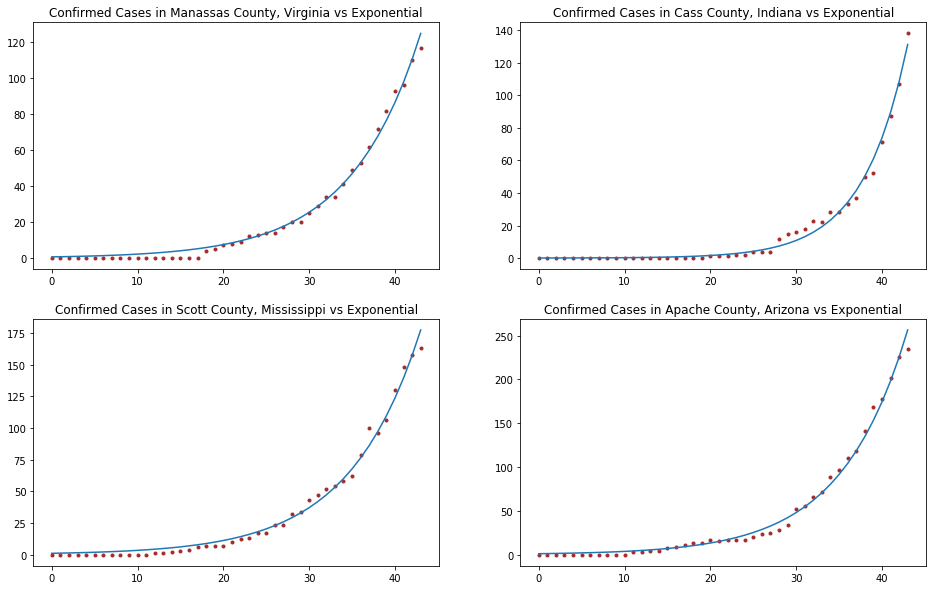

In [10]:
# The R^2 metrics divide the time series into several groups. Let's look at
# examples of each of these groups in turn.
#
# Show some example time series for which a single exponential curve
# has R^2 above 0.99
util.graph_examples(curves, ts_col_name, {"Exponential": curves["Exponential"]},
                    mask=stats['Exp_R^2'] >= r2_thresh)

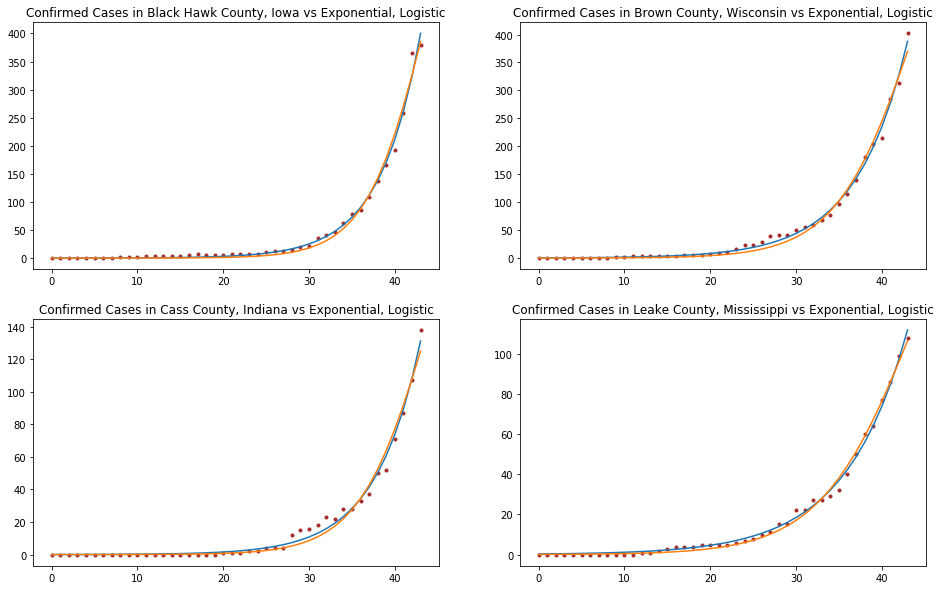

In [11]:
# Are there any time series that fit an exponential curve with R^2 > 0.99
# and fit that exponential curve *better* than they fit a logistic curve?
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=(stats['Exp_R^2'] >= r2_thresh) & (stats['Exp_R^2'] > stats['Log_R^2']))

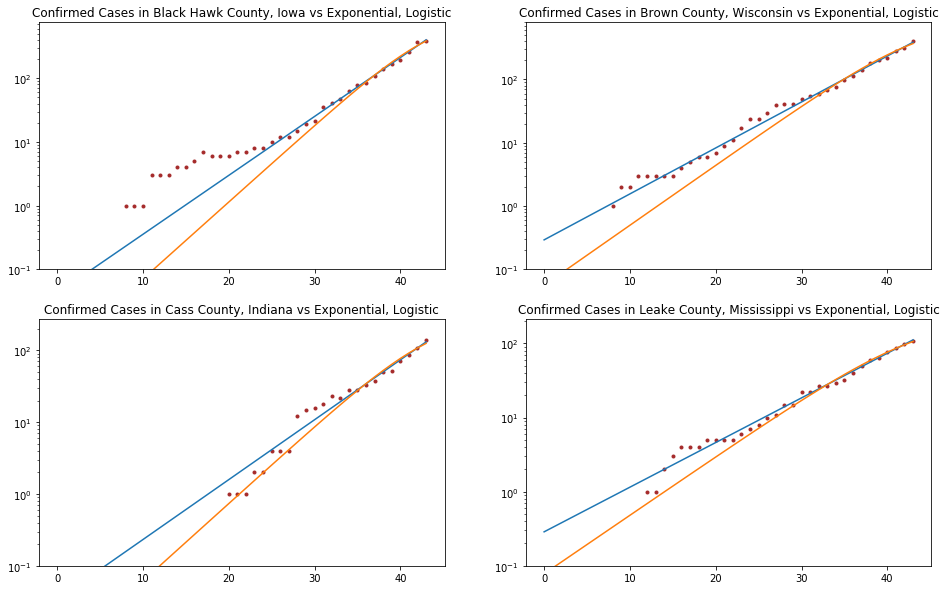

In [12]:
# Previous plots with a log scale on the Y axis
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=(stats['Exp_R^2'] >= r2_thresh) & (stats['Exp_R^2'] > stats['Log_R^2']),
                    semilog=True)

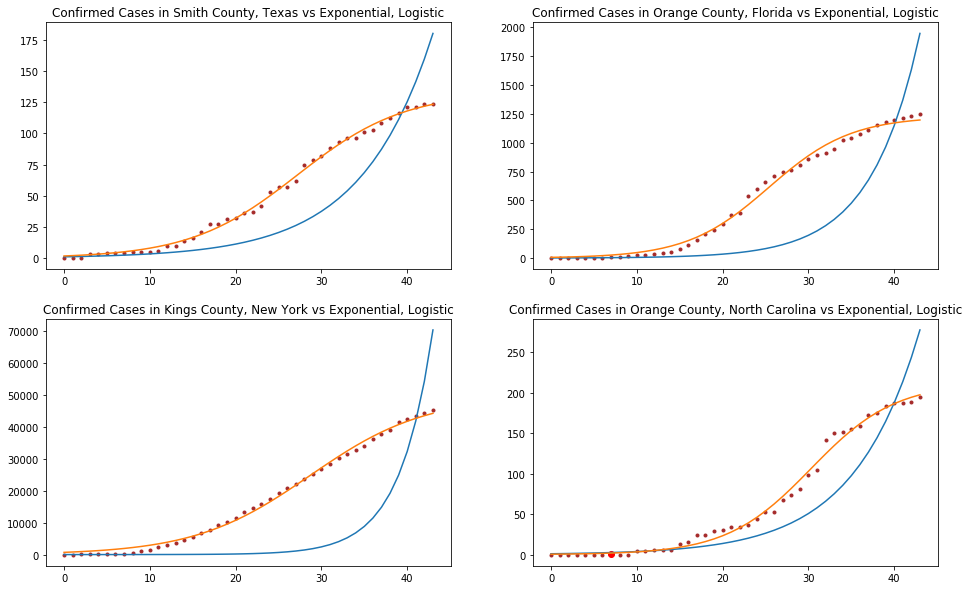

In [13]:
# Let's look at some examples where logistic growth (with a single
# instance of the logistic function) produces a good fit, while an
# exponential growth model does not.
mask = (stats['Log_R^2'] >= r2_thresh) & (stats['Exp_R^2'] < 0.95)
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=mask)

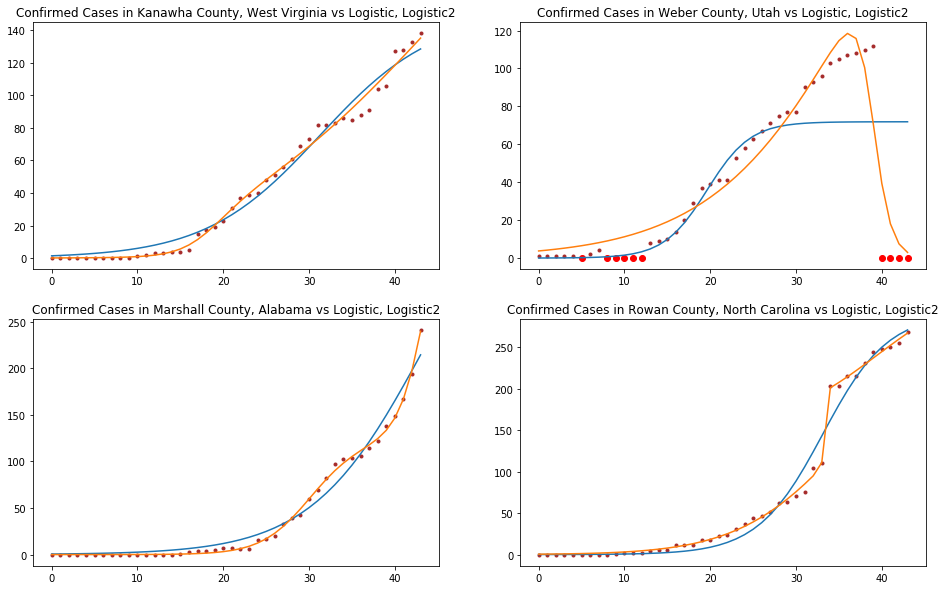

In [14]:
# Look at cases where a mixture of two logistic growth models explains
# the data better than a single logistic growth model.
mask = stats['Log2_R^2'] - stats['Log_R^2'] >= 0.01
#graph_examples(mask, {"Logistic": logistic, "Logistic2": logistic2}, num_to_pick=10)
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=mask)

In [15]:
# Many of these dual-logistic curves have low values for the rate of the
# second logistic function.
# Across the entire data set, what models have logistic rate2 near zero?
small_rate2_mask = params["Log2_Rate2"] < 5e-2
params[small_rate2_mask][metadata_cols + [c for c in params.columns if c.startswith("Log2")]]

,State,County,Population,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,
4001,Arizona,Apache,71887,7.850673e+02,2.566654e-01,43.066041,267.398775,4.399757e-02,43.999881,33.407183,43.986842
6041,California,Marin,258826,4.207309e+02,7.710133e-01,24.816082,418.337712,4.626738e-02,43.999264,6.860770,11.379257
6053,California,Monterey,434061,2.802458e+02,9.930905e-01,39.352116,279.581789,4.053332e-02,44.000000,16.156054,24.723534
6085,California,Santa Clara,1927852,7.993622e+02,2.267322e-01,17.975475,4407.608821,0.000000e+00,13.916922,25.094507,32.139415
8051,Colorado,Gunnison,17462,2.654188e+02,1.648706e-01,27.708608,239.230973,2.794315e-02,44.000000,10.518564,12.013140
9003,Connecticut,Hartford,891720,8.842042e+02,0.000000e+00,5.999402,5018.387582,4.293651e-09,8.186002,18.306353,17.306353
12031,Florida,Duval,957755,1.869546e+03,1.359722e+00,39.490484,1872.443135,4.186240e-02,44.000000,16.679765,20.665197
12086,Florida,Miami-Dade,2716940,2.155606e+03,1.424738e-02,3.422045,9603.811938,4.386598e-02,1.607431,19.824978,18.824978
12095,Florida,Orange,1393452,2.598448e+03,1.000000e+01,33.675407,2608.700975,4.626192e-02,44.000000,14.240068,17.252678


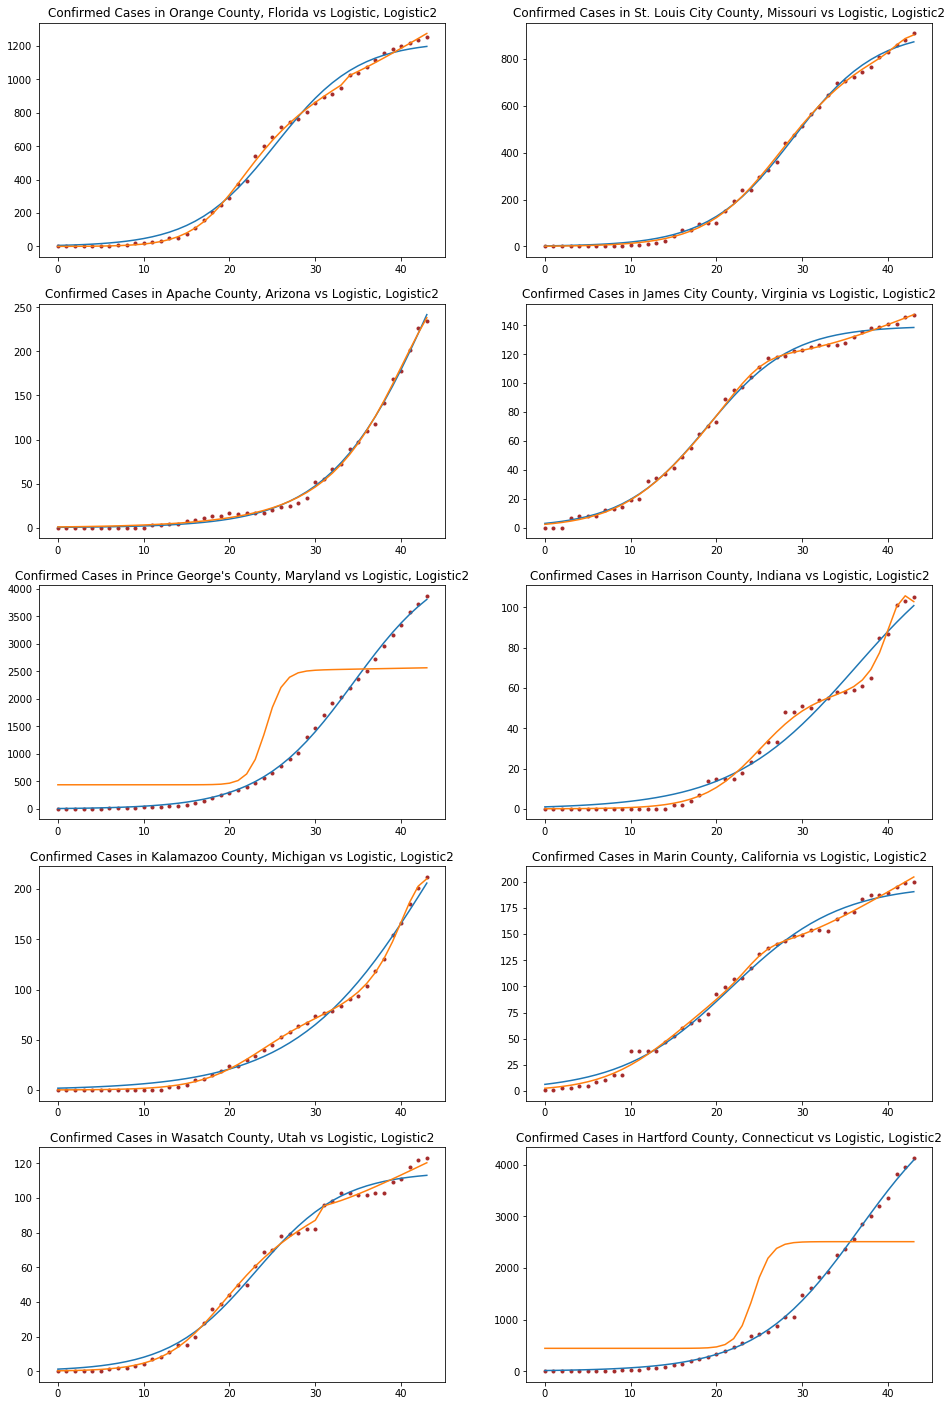

In [16]:
# Show some examples of these cases where Rate2 is small
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=small_rate2_mask,
                    num_to_pick=10)

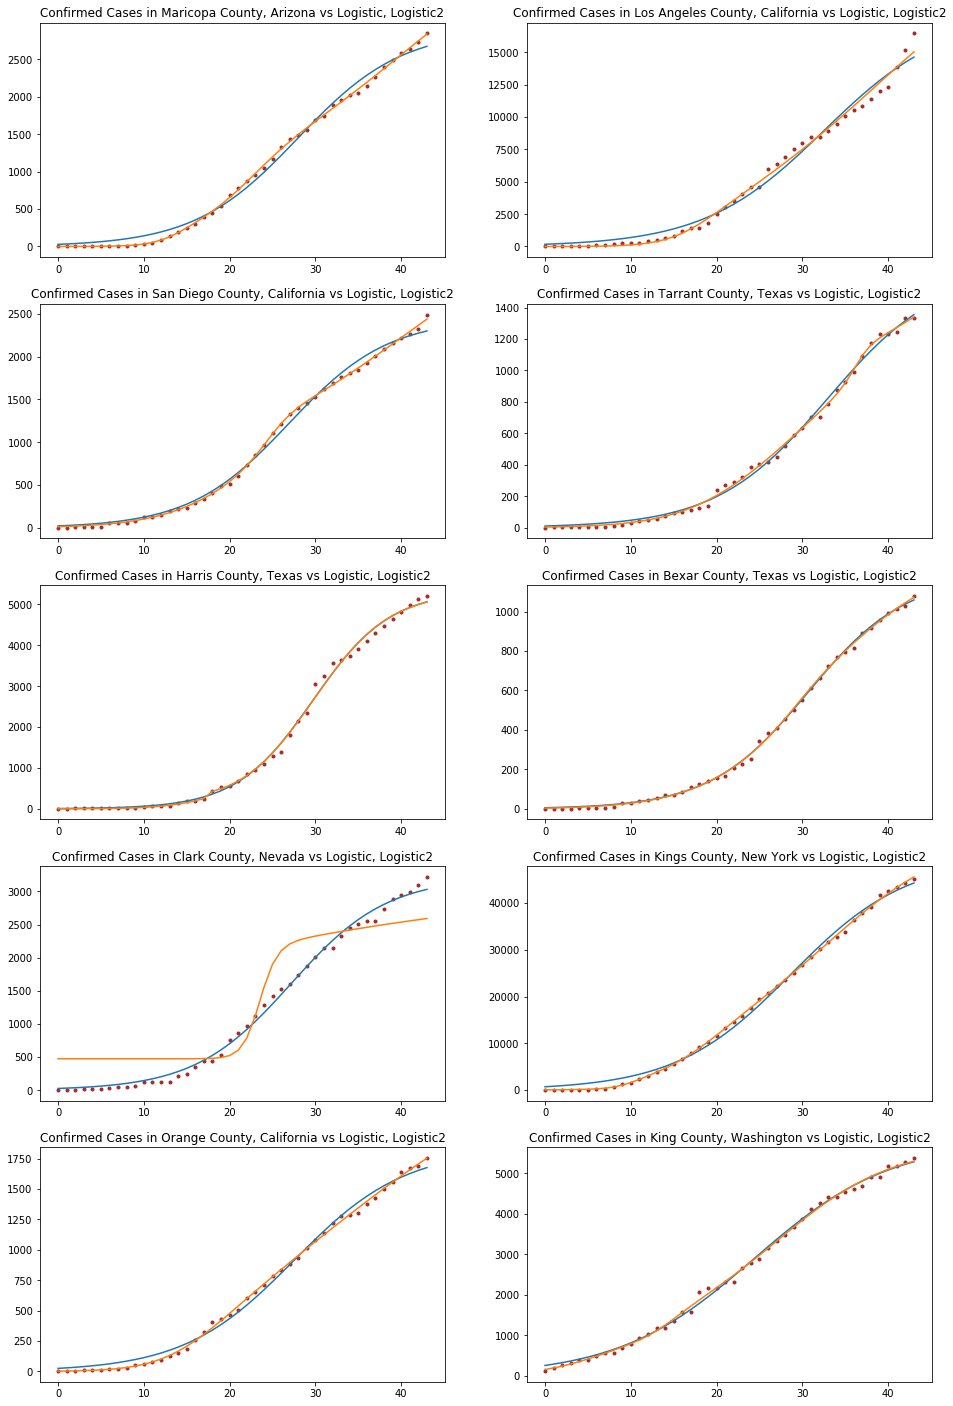

In [17]:
# What about populous counties?
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=curves["Population"] > 2e6,
                    num_to_pick=10)

In [18]:
# What time series are *not* explained by any of our curves?
non_fitting_mask = (stats["Exp_R^2"] < 0.99) & (stats["Log_R^2"] < 0.99) & (stats["Log2_R^2"] < 0.99)
stats[non_fitting_mask]

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
5079,Arkansas,Lincoln,13024,0.971440,0.962180,0.977664
13035,Georgia,Butts,24936,0.935269,0.910093,0.986685
13071,Georgia,Colquitt,45600,0.885949,0.974204,0.987140
18029,Indiana,Dearborn,49458,0.627709,0.896133,0.930246
19171,Iowa,Tama,16854,0.977959,0.984515,0.985405
20111,Kansas,Lyon,33195,0.959737,0.940382,0.939801
21107,Kentucky,Hopkins,44686,0.931013,0.981675,0.985599
21227,Kentucky,Warren,132896,0.989265,0.986757,0.989731
22097,Louisiana,St. Landry,82124,0.718310,0.981254,0.984383


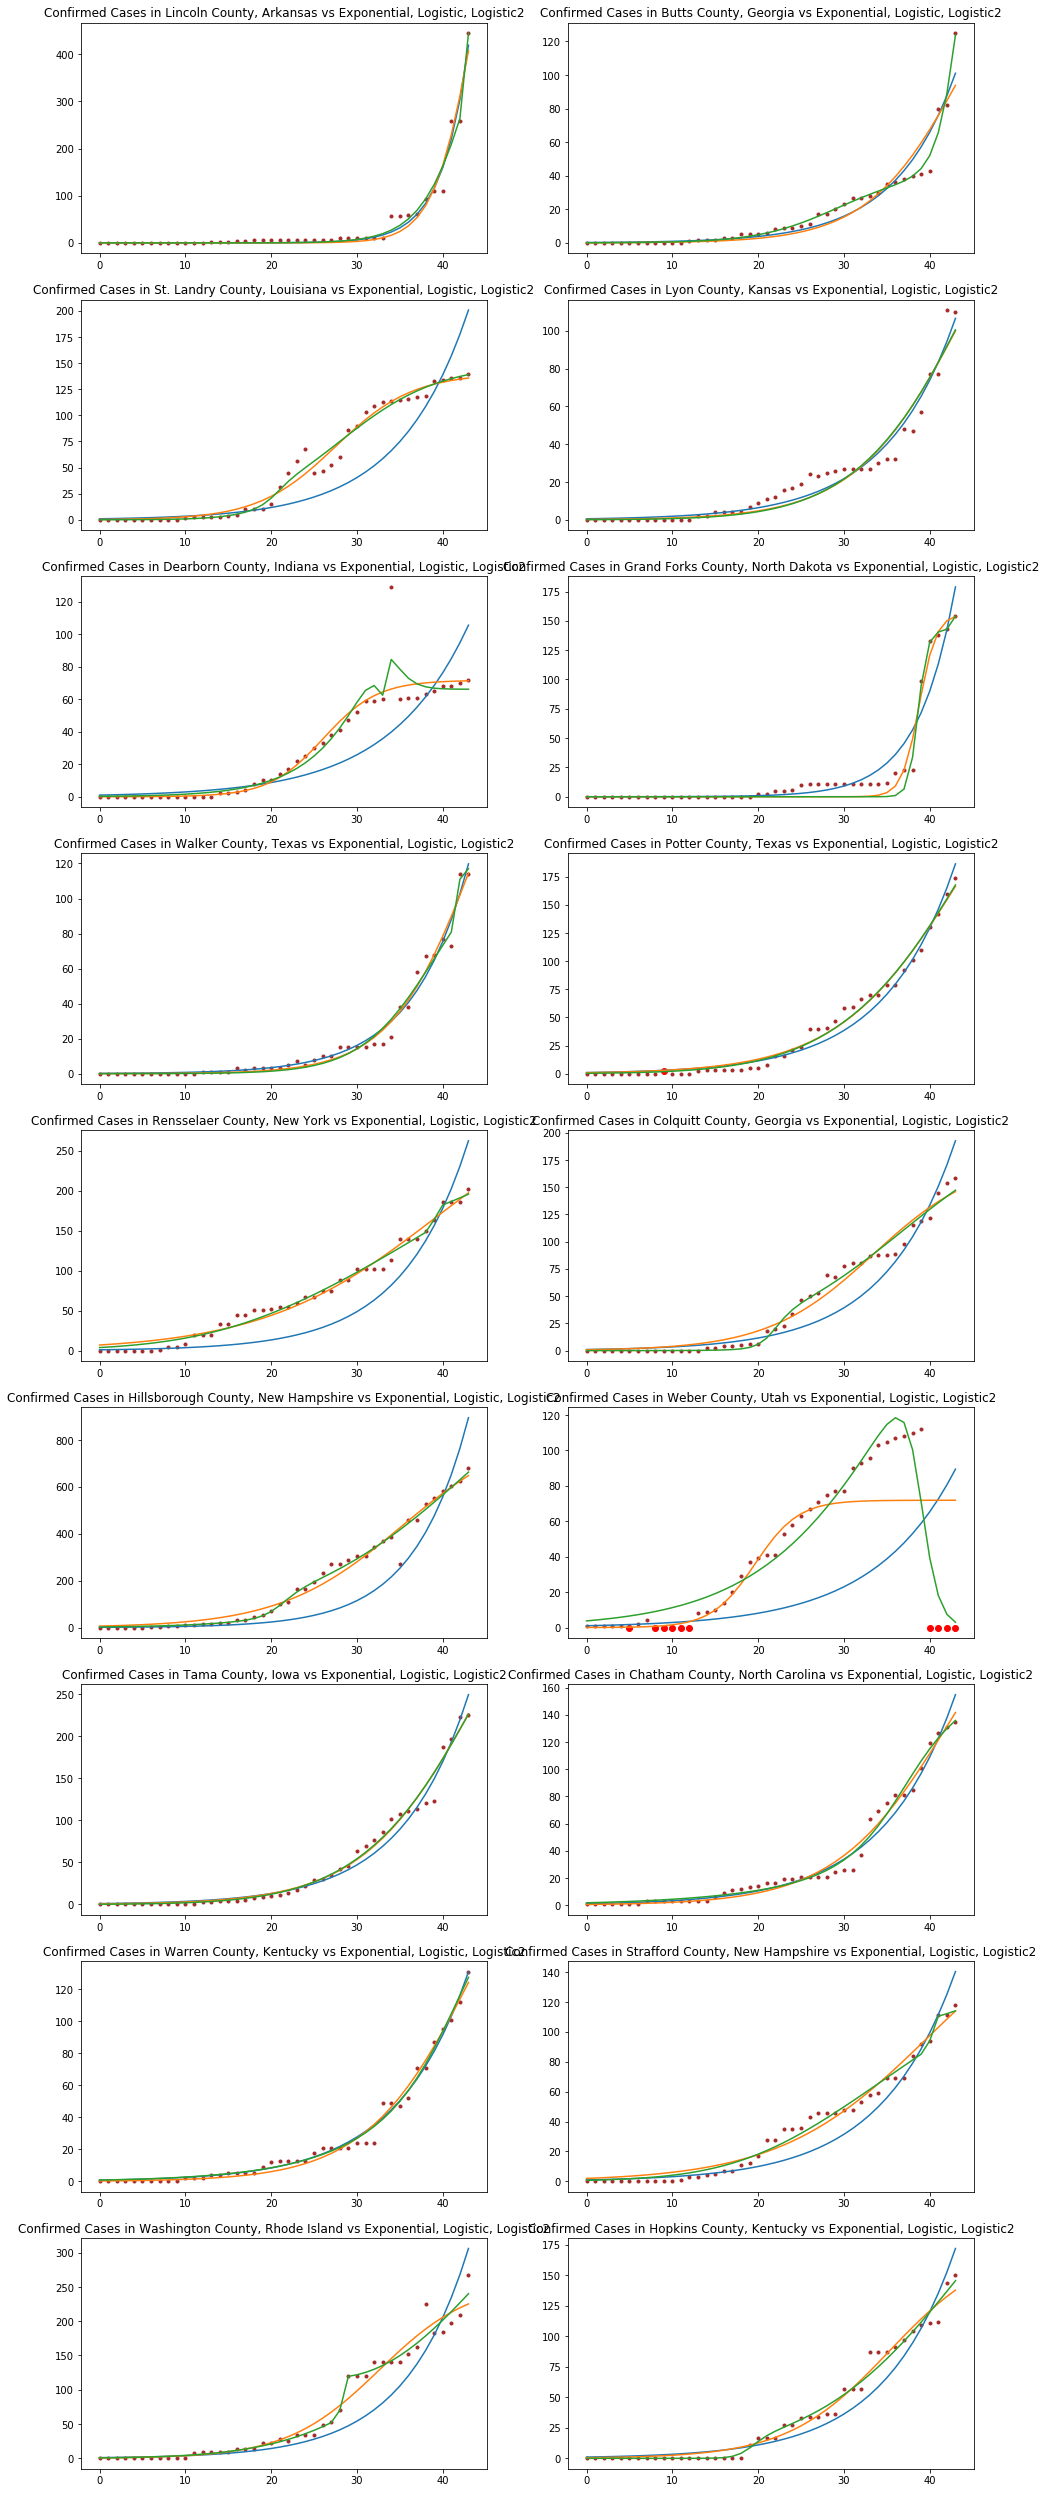

In [19]:
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=non_fitting_mask,
                    num_to_pick=20)